# Import

In [1]:
import sys
sys.path.append("..")  # Adds the parent directory to the system pat

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import math

from script.data_handler import *

# Manual

In [2]:
OR_DATA_FILE_NAME = "Design_review_10_02_2024.csv"
RAS_DATA_FILE_NAME = "RAS_Flight_Data.csv"
RAS_DATA_MACH_CD_FILE_NAME = "Ras__CD_Before_Raw.CSV"
DATA_DIRECTORY = "data"
MOTOR_NAME = "M1297"
ROCKET_LENGTH = 2860
ALTITUDE_INCREMENTS = 1000
VERTICAL_MOTION_INCREMENTS = 50
AVERAGE_THRUST = 0
MAX_MACH_RAS_OR_COMPARISON = 1

FLIGHT_PROFILE_PLOT_TITLE = f"{MOTOR_NAME} Motor - Vertical Motion vs Time"
# Columns to consider for vertical motion
VERTICAL_MOTION_COLUMNS = ['vertical_velocity', 'vertical_acceleration']

# Read CSV

In [3]:
# Get the current working directory (should be 'Notebooks')
cwd = os.getcwd()
# Go up one level to the project directory
project_dir = os.path.join(cwd, '..')
# Construct the path to the CSV file in the 'data' directory
or_csv_path = os.path.join(project_dir, DATA_DIRECTORY, OR_DATA_FILE_NAME)
# Normalize the path (optional but recommended)
or_csv_path = os.path.normpath(or_csv_path)

ras_csv_path = os.path.join(project_dir, DATA_DIRECTORY, RAS_DATA_FILE_NAME)
# Normalize the path (optional but recommended)
ras_csv_path = os.path.normpath(ras_csv_path)

ras_mach_cd_csv_path = os.path.join(
    project_dir, DATA_DIRECTORY, RAS_DATA_MACH_CD_FILE_NAME)
# Normalize the path (optional but recommended)
ras_mach_cd_csv_path = os.path.normpath(ras_mach_cd_csv_path)

dh = DataHandler(or_filepath=or_csv_path)
dh.rename_or_df_columns()
# dh.rename_ras_df_columns()
# dh.convert_ras_units_to_SI()
# dh.rename_ras_mach_cd_df_columns()

display(dh.merged_df)
# display(dh.ras_df)
# display(dh.filtered_ras_df)

,time,altitude,vertical_velocity,vertical_acceleration,total_velocity,total_acceleration,position_east_of_launch,position_north_of_launch,lateral_distance,lateral_direction,...,reference_area,vertical_orientation_zenith,lateral_orientation_azimuth,wind_velocity,air_temperature,air_pressure,speed_of_sound,simulation_time_step,computation_time,event
0,0.010000,-0.000769,-0.046854,-4.684780,0.046854,4.684780,0.000000,0.000000,0.000000,0.000000,...,184.334834,90.000000,0.000000,2.052469,15.000000,1013.250000,340.388900,0.01,0.016397,NaN
1,0.020000,0.000907,0.055320,5.533950,0.055320,5.533950,0.000000,0.000000,0.000000,0.000000,...,184.334834,90.000000,0.000000,2.044192,14.999998,1013.249968,340.388899,0.01,0.019985,NaN
2,0.030000,0.005307,0.212866,15.757927,0.212866,15.757927,0.000000,0.000000,0.000000,0.000000,...,184.334834,90.000000,0.000000,2.035916,14.999989,1013.249810,340.388894,0.01,0.022746,NaN
3,0.040000,0.016552,0.472692,25.987130,0.472692,25.987130,0.000000,0.000000,0.000000,0.000000,...,184.334834,90.000000,0.000000,2.027639,14.999967,1013.249408,340.388880,0.01,0.025078,NaN
4,0.050000,0.038001,0.834848,36.221483,0.834848,36.221483,0.000000,0.000000,0.000000,0.000000,...,184.334834,90.000000,0.000000,2.019362,14.999925,1013.248642,340.388854,0.01,0.026794,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3967,196.820313,9.685987,-17.239582,-0.162334,27.710113,0.256287,-12383.337384,-57.079073,12383.468932,-179.735906,...,184.334834,2.384357,0.828702,2.092630,14.980810,1012.903745,340.377271,0.05,1.834467,NaN
3968,196.870313,6.857347,-17.246943,-0.132063,27.722346,0.233526,-12386.896685,-57.125103,12387.028407,-179.735769,...,184.334834,2.360163,0.829313,1.958806,14.986414,1013.004863,340.380667,0.05,1.834805,NaN
3969,196.920313,4.027624,-17.252786,-0.102053,27.733388,0.212002,-12390.457564,-57.171192,12390.589461,-179.735632,...,184.334834,2.327559,0.829924,1.841030,14.992020,1013.106020,340.384064,0.05,1.835141,NaN
3970,196.970313,1.197065,-17.257209,-0.079686,27.743267,0.196030,-12394.019965,-57.217348,12394.152038,-179.735494,...,184.334834,2.285088,0.830537,1.815465,14.997628,1013.207207,340.387463,0.05,1.835476,NaN


# Calculations

In [4]:
dh.merged_df["stability_margin_percentage"] = (
    dh.merged_df["cp_location"] - dh.merged_df["cg_location"]) / ROCKET_LENGTH * 100

In [5]:
APOGEE_TIME = dh.comments_df[dh.comments_df["Event"] == "APOGEE"]["Time (s)"].values[0]
BURNOUT_TIME = dh.comments_df[dh.comments_df["Event"]
                              == "BURNOUT/EJECTION_CHARGE"]["Time (s)"].values[0]

# Functions

In [6]:
def round_to_increment(values, increment, direction):
    if direction == 'up': 
        return math.ceil(max(values) / increment) * increment
    elif direction == 'down':
        return math.floor(min(values) / increment) * increment

# Font 

In [7]:
plt.rcParams.update({
    'text.usetex': True,
    'text.latex.preamble': r'\usepackage{times}',
    'font.family': 'serif',
    'font.serif': ['Times New Roman', 'Times'],
})

# Open Rocket Flight Profile

In [8]:
max_altitude = round_to_increment(
    dh.merged_df["altitude"], ALTITUDE_INCREMENTS, 'up')
max_vertical_motion = round_to_increment(
    dh.merged_df[VERTICAL_MOTION_COLUMNS].max(), VERTICAL_MOTION_INCREMENTS, 'up')
min_vertical_motion = round_to_increment(
    dh.merged_df[VERTICAL_MOTION_COLUMNS].min(), VERTICAL_MOTION_INCREMENTS, 'down')

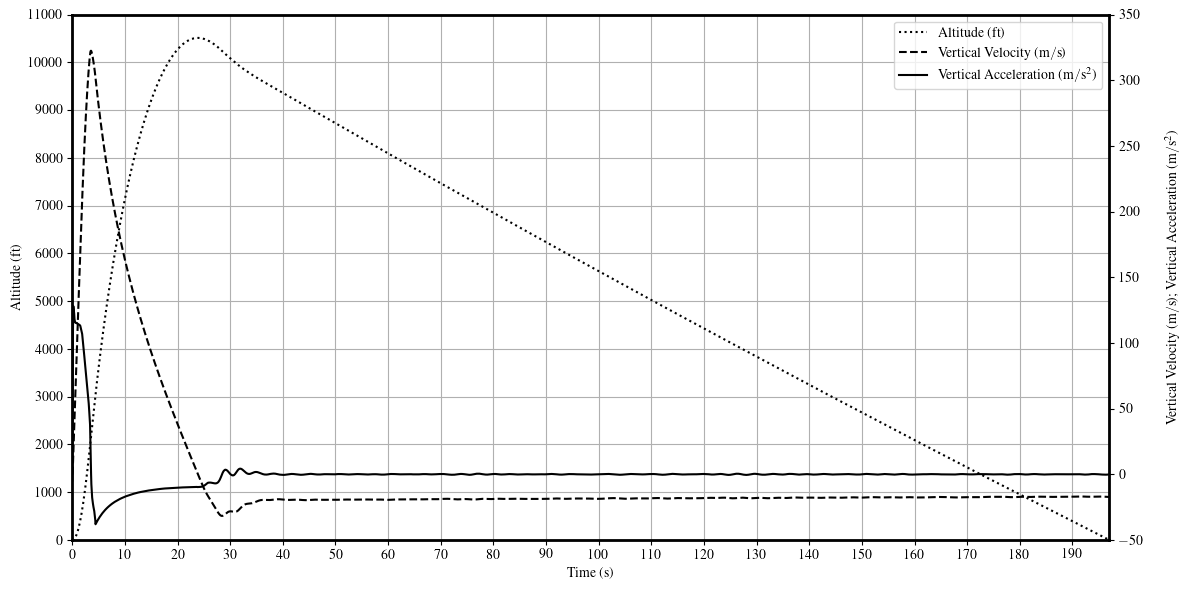

In [9]:
# Create plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Altitude
ax1.plot(dh.merged_df["time"], dh.merged_df["altitude"],
         "k:", label="Altitude ($\mathrm{ft}$)")
ax1.set_xlabel(r"Time ($\mathrm{s}$)")
ax1.set_ylabel(r"Altitude ($\mathrm{ft}$)")
ax1.set_xlim(0, dh.merged_df["time"].max())
ax1.set_ylim(0, max_altitude)
ax1.set_yticks(range(0, max_altitude + 1, ALTITUDE_INCREMENTS))
# Set x-axis ticks at regular intervals
ax1.set_xticks(np.arange(0, dh.merged_df["time"].max(), 10))
ax1.grid(True)

# Plot Vertical velocity and acceleration
ax2 = ax1.twinx()
ax2.plot(
    dh.merged_df["time"],
    dh.merged_df["vertical_velocity"],
    "k--",
    label="Vertical Velocity ($\mathrm{m/s}$)"
)
ax2.plot(
    dh.merged_df["time"],
    dh.merged_df["vertical_acceleration"],
    "k-",
    label="Vertical Acceleration ($\mathrm{m/s^2}$)"
)
ax2.set_ylabel(
    "Vertical Velocity ($\mathrm{m/s}$); Vertical Acceleration ($\mathrm{m/s^2}$)", labelpad=15
)
ax2.set_ylim(min_vertical_motion, max_vertical_motion)
ax2.set_yticks(
    np.arange(
        min_vertical_motion,
        max_vertical_motion + 1,
        VERTICAL_MOTION_INCREMENTS,
    )
)

# Change spine properties to make the border darker and thicker
for spine in ax1.spines.values():
    spine.set_edgecolor('black')  # Change color to black or any other color
    # Change the thickness. Adjust the value as needed.
    spine.set_linewidth(2)

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper right")

fig.tight_layout()

# # Plot event markers
# self.plot_event_markers(ax1)

plt.show()

# Open Rocket Flight Profile to Apogee

In [10]:
temp_or_df = dh.merged_df.copy(deep=True)
temp_or_df = temp_or_df[temp_or_df["time"]
                        <= APOGEE_TIME]

max_altitude = round_to_increment(
    dh.merged_df["altitude"], ALTITUDE_INCREMENTS, 'up')
max_vertical_motion = round_to_increment(
    dh.merged_df[VERTICAL_MOTION_COLUMNS].max(), VERTICAL_MOTION_INCREMENTS, 'up')
min_vertical_motion = round_to_increment(
    dh.merged_df[VERTICAL_MOTION_COLUMNS].min(), VERTICAL_MOTION_INCREMENTS, 'down')

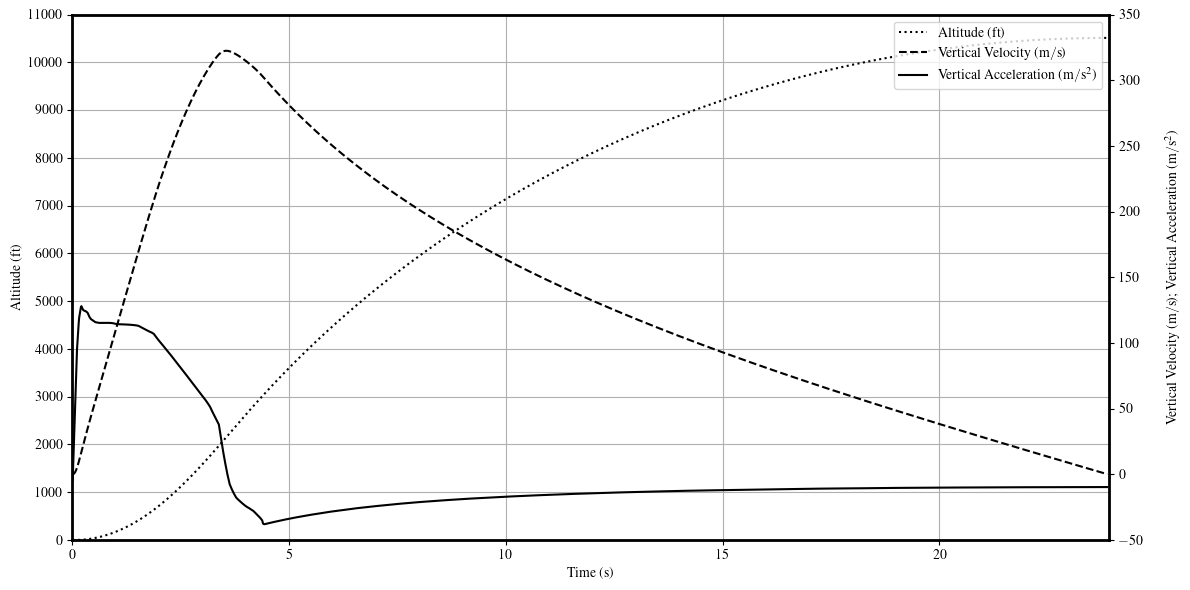

In [11]:
# Create plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Altitude
ax1.plot(temp_or_df["time"], temp_or_df["altitude"],
         "k:", label="Altitude ($\mathrm{ft}$)")
ax1.set_xlabel(r"Time ($\mathrm{s}$)")
ax1.set_ylabel(r"Altitude ($\mathrm{ft}$)")
ax1.set_xlim(0, APOGEE_TIME)
ax1.set_ylim(0, max_altitude)
ax1.set_yticks(range(0, max_altitude + 1, ALTITUDE_INCREMENTS))
# Set x-axis ticks at regular intervals
ax1.set_xticks(np.arange(0, APOGEE_TIME, 5))
ax1.grid(True)

# Plot Vertical velocity and acceleration
ax2 = ax1.twinx()
ax2.plot(
    temp_or_df["time"],
    temp_or_df["vertical_velocity"],
    "k--",
    label="Vertical Velocity ($\mathrm{m/s}$)",
)
ax2.plot(
    temp_or_df["time"],
    temp_or_df["vertical_acceleration"],
    "k-",
    label="Vertical Acceleration ($\mathrm{m/s^2}$)",
)
ax2.set_ylabel(
    "Vertical Velocity ($\mathrm{m/s}$); Vertical Acceleration ($\mathrm{m/s^2}$)", labelpad=15
)
ax2.set_ylim(min_vertical_motion, max_vertical_motion)
ax2.set_yticks(
    np.arange(
        min_vertical_motion,
        max_vertical_motion + 1,
        VERTICAL_MOTION_INCREMENTS,
    )
)

# Change spine properties to make the border darker and thicker
for spine in ax1.spines.values():
    spine.set_edgecolor('black')  # Change color to black or any other color
    # Change the thickness. Adjust the value as needed.
    spine.set_linewidth(2)

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper right")

# plt.title(FLIGHT_PROFILE_PLOT_TITLE)
fig.tight_layout()

# # Plot event markers
# self.plot_event_markers(ax1)

plt.show()

# RasAero Flight Profile

In [12]:
max_altitude = round_to_increment(
    dh.ras_df["altitude"], ALTITUDE_INCREMENTS, 'up')
max_vertical_motion = round_to_increment(
    dh.ras_df[VERTICAL_MOTION_COLUMNS].max(), VERTICAL_MOTION_INCREMENTS, 'up')
min_vertical_motion = round_to_increment(
    dh.ras_df[VERTICAL_MOTION_COLUMNS].min(), VERTICAL_MOTION_INCREMENTS, 'down')

TypeError: 'NoneType' object is not subscriptable

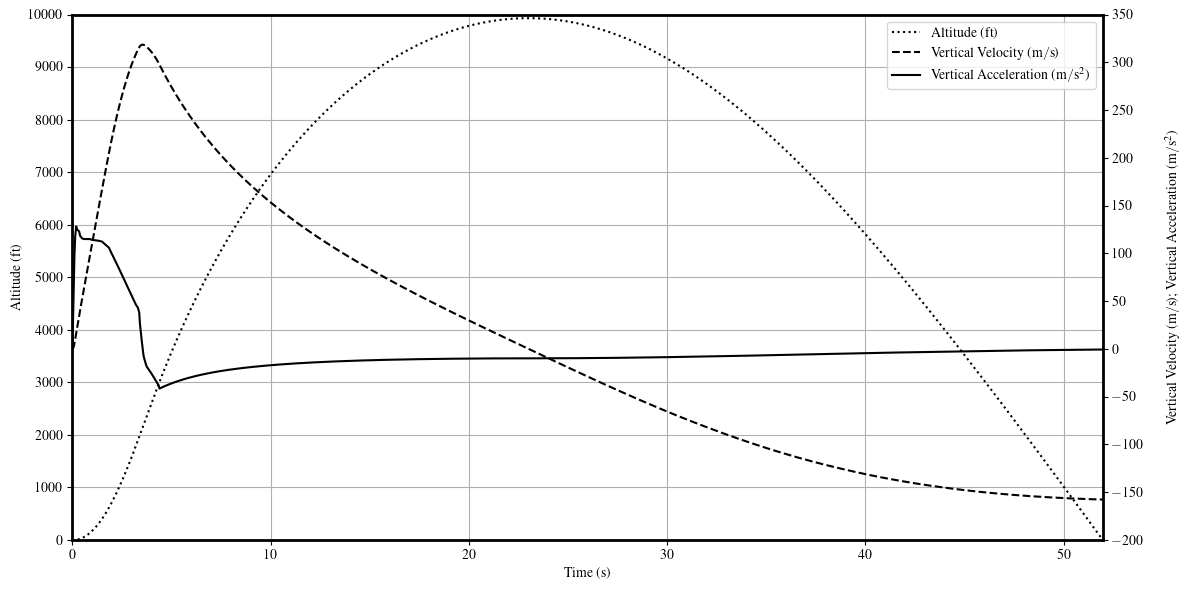

In [ ]:
# Create plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Altitude
ax1.plot(dh.ras_df["time"], dh.ras_df["altitude"],
         "k:", label="Altitude ($\mathrm{ft}$)")
ax1.set_xlabel(r"Time ($\mathrm{s}$)")
ax1.set_ylabel(r"Altitude ($\mathrm{ft}$)")
ax1.set_xlim(0, dh.ras_df["time"].max())
ax1.set_ylim(0, max_altitude)
ax1.set_yticks(range(0, max_altitude + 1, ALTITUDE_INCREMENTS))
# Set x-axis ticks at regular intervals
ax1.set_xticks(np.arange(0, dh.ras_df["time"].max(), 10))
ax1.grid(True)

# Plot Vertical velocity and acceleration
ax2 = ax1.twinx()
ax2.plot(
    dh.ras_df["time"],
    dh.ras_df["vertical_velocity"],
    "k--",
    label="Vertical Velocity ($\mathrm{m/s}$)",
)
ax2.plot(
    dh.ras_df["time"],
    dh.ras_df["vertical_acceleration"],
    "k-",
    label="Vertical Acceleration ($\mathrm{m/s^2}$)",
)
ax2.set_ylabel(
    "Vertical Velocity ($\mathrm{m/s}$); Vertical Acceleration ($\mathrm{m/s^2}$)", labelpad=15
)
ax2.set_ylim(min_vertical_motion, max_vertical_motion)
ax2.set_yticks(
    np.arange(
        min_vertical_motion,
        max_vertical_motion + 1,
        VERTICAL_MOTION_INCREMENTS,
    )
)

# Change spine properties to make the border darker and thicker
for spine in ax1.spines.values():
    spine.set_edgecolor('black')  # Change color to black or any other color
    # Change the thickness. Adjust the value as needed.
    spine.set_linewidth(2)

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper right")

# plt.title(FLIGHT_PROFILE_PLOT_TITLE)
fig.tight_layout()

# # Plot event markers
# self.plot_event_markers(ax1)

plt.show()

# RasAero Mach vs Cd

In [ ]:
max_drag = math.ceil(dh.filtered_ras_df["drag_coefficient"].max() * 10) / 10
max_mach = math.ceil(dh.filtered_ras_df["mach_number"].max() * 10) / 10

# Find the data range for the drag coefficient
min_drag_coefficient = dh.filtered_ras_df["drag_coefficient"].min()
max_drag_coefficient = dh.filtered_ras_df["drag_coefficient"].max()

# Add a buffer to the min and max
buffer = (max_drag_coefficient - min_drag_coefficient) * 0.1  # 10% buffer
min_limit = max(min_drag_coefficient - buffer, 0)  # Avoid negative lower limit
max_limit = max_drag_coefficient + buffer

max_drag_rounded = math.ceil(max_limit * 10) / 10
min_drag_rounded = math.floor(min_limit * 10) / 10

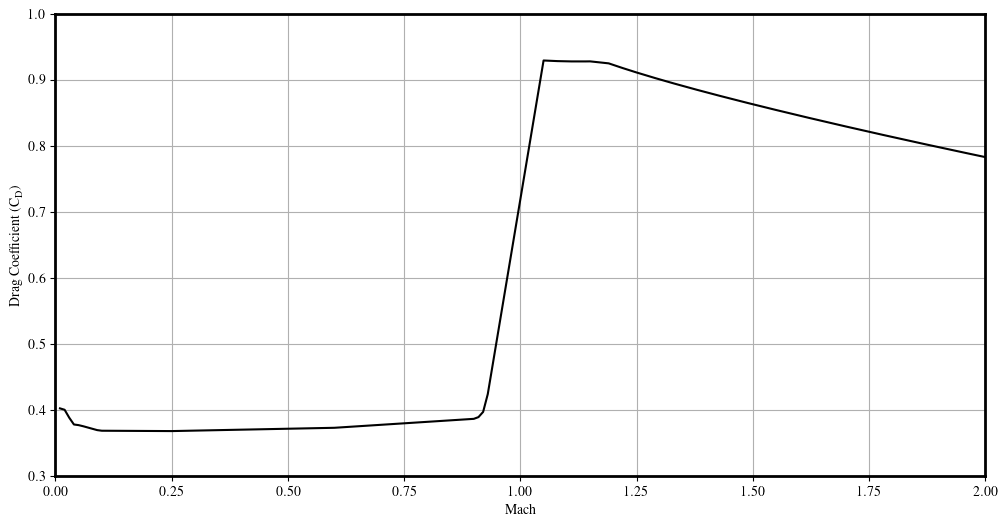

In [ ]:
fig, ax1 = plt.subplots(figsize=(12, 6))
        
ax1.set_xlabel(r"Mach")
ax1.set_ylabel(r"Drag Coefficient ($\mathrm{C_D}$)")
ax1.grid(True)
ax1.plot(dh.filtered_ras_df["mach_number"],
            dh.filtered_ras_df["drag_coefficient"], color='k', label="Drag Coefficient")
ax1.set_ylim(min_drag_rounded, max_drag_rounded)
ax1.set_xlim(0,max_mach)

# Change spine properties to make the border darker and thicker
for spine in ax1.spines.values():
    spine.set_edgecolor('black')  # Change color to black or any other color
    # Change the thickness. Adjust the value as needed.
    spine.set_linewidth(2)

# ax1.set_yticks(np.arange(0, max_drag+0.1, 0.05))

# Plot event markers
# self.plot_event_markers_mach(ax1)

plt.show()

# OpenRocket & RasAero Mach vs Cd

In [ ]:
temp_ras_df = dh.filtered_ras_df.copy(deep=True)
temp_ras_df = temp_ras_df[temp_ras_df["mach_number"]
                          <= MAX_MACH_RAS_OR_COMPARISON]

max_drag = math.ceil(temp_ras_df["drag_coefficient"].max() * 10) / 10
max_mach = math.ceil(temp_ras_df["mach_number"].max() * 10) / 10

# Find the data range for the drag coefficient
min_drag_coefficient = temp_ras_df["drag_coefficient"].min()
max_drag_coefficient = temp_ras_df["drag_coefficient"].max()

# Add a buffer to the min and max
buffer = (max_drag_coefficient - min_drag_coefficient) * 0.1  # 10% buffer
min_limit = max(min_drag_coefficient - buffer, 0)  # Avoid negative lower limit
max_limit = max_drag_coefficient + buffer

max_drag_rounded = math.ceil(max_limit * 10) / 10
min_drag_rounded = math.floor(min_limit * 10) / 10

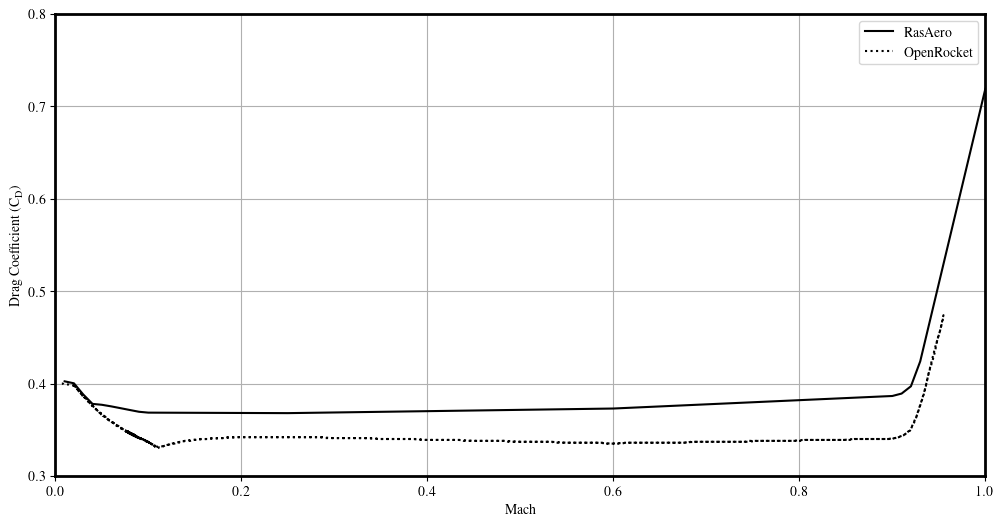

In [ ]:
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.set_xlabel(r"Mach")
ax1.set_ylabel(r"Drag Coefficient ($\mathrm{C_D}$)")
ax1.grid(True)
ax1.plot(temp_ras_df["mach_number"],
         temp_ras_df["drag_coefficient"], color='k', linestyle='-', label="RasAero")
ax1.plot(dh.merged_df["mach_number"],
         dh.merged_df["drag_coefficient"], color='k', linestyle=':', label="OpenRocket")
ax1.set_ylim(min_drag_rounded, max_drag_rounded)
ax1.set_xlim(0, MAX_MACH_RAS_OR_COMPARISON)

# Change spine properties to make the border darker and thicker
for spine in ax1.spines.values():
    spine.set_edgecolor('black')  # Change color to black or any other color
    # Change the thickness. Adjust the value as needed.
    spine.set_linewidth(2)

# Adding the legend
plt.legend()

# ax1.set_yticks(np.arange(0, max_drag+0.1, 0.05))

# Plot event markers
# self.plot_event_markers_mach(ax1)

plt.show()

# Stability vs Time

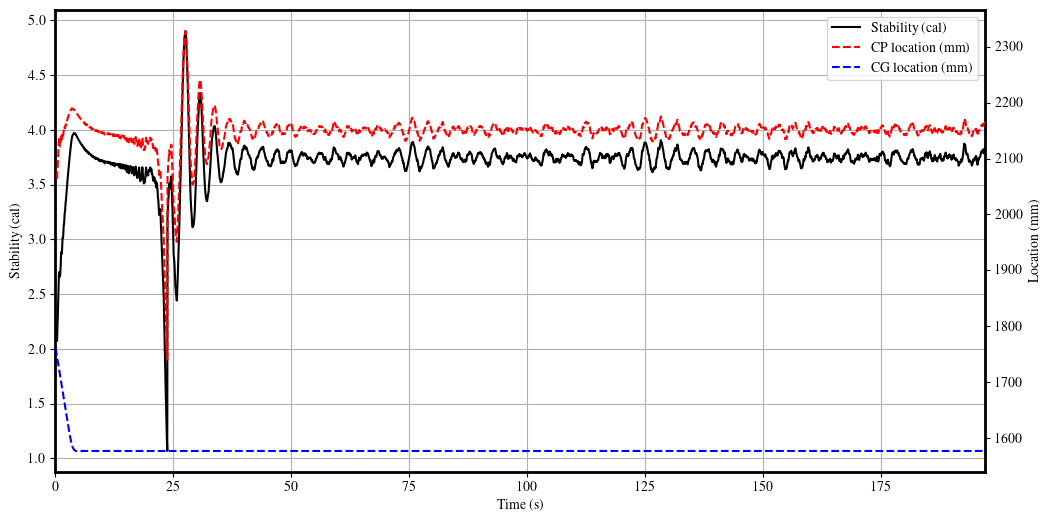

In [13]:
"""Plot Stability data."""
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(dh.merged_df["time"], dh.merged_df["stability_margin_calibers"],
         "k-", label="Stability ($\mathrm{cal}$)")

ax1.set_xlabel(r"Time ($\mathrm{s}$)")
ax1.set_ylabel(r"Stability ($\mathrm{cal}$)")
ax1.grid(True)

# Plot CP and CG location on a secondary axis
ax2 = ax1.twinx()
ax2.plot(dh.merged_df["time"], dh.merged_df["cp_location"],
         "r--", label="CP location ($\mathrm{mm}$)")
ax2.plot(dh.merged_df["time"], dh.merged_df["cg_location"],
         "b--", label="CG location ($\mathrm{mm}$)")
ax2.set_ylabel("Location ($\mathrm{mm}$)")

# Set x-axis limits based on SHOW_FULL_STABILITY_GRAPH
ax1.set_xlim(0, dh.merged_df["time"].max())

# Combine legends from ax1 and ax2
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc="upper right")

# Change spine properties to make the border darker and thicker
for spine in ax1.spines.values():
    spine.set_edgecolor('black')  # Change color to black or any other color
    # Change the thickness. Adjust the value as needed.
    spine.set_linewidth(2)

# Plot event markers
# self.plot_event_markers(ax1)

# plt.title(f"{self.MOTOR_NAME} Motor - {y_label} vs Time(s)")
plt.show()

# Stability vs Time Calibers Burnout

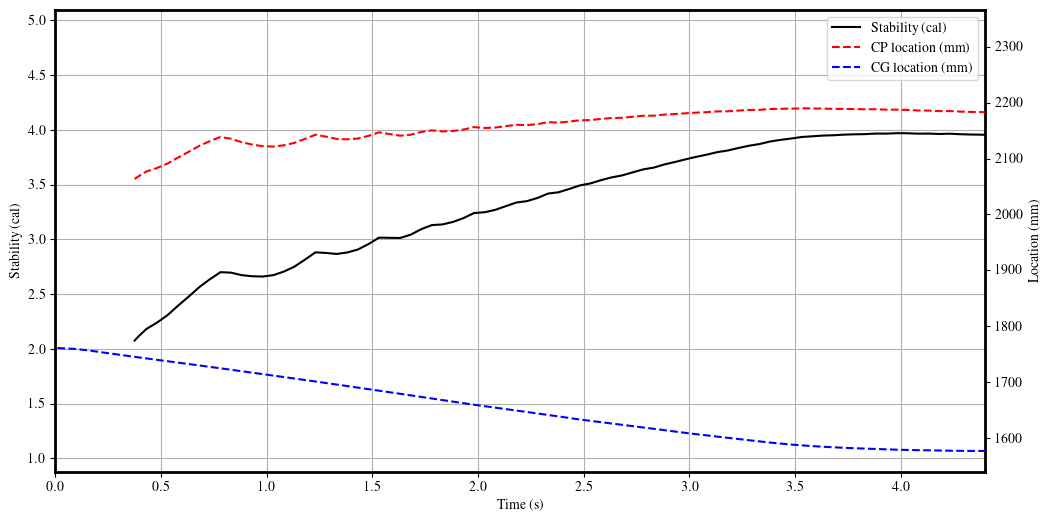

In [14]:
"""Plot Stability data."""
fig, ax1 = plt.subplots(figsize=(12, 6))

# Select y-axis data based on STABILITY_UNIT and plot
ax1.plot(dh.merged_df["time"], dh.merged_df["stability_margin_calibers"],
         "k-", label="Stability ($\mathrm{cal}$)")

ax1.set_xlabel(r"Time ($\mathrm{s}$)")
ax1.set_ylabel(r"Stability ($\mathrm{cal}$)")
ax1.grid(True)

# Plot CP and CG location on a secondary axis
ax2 = ax1.twinx()
ax2.plot(dh.merged_df["time"], dh.merged_df["cp_location"],
         "r--", label="CP location ($\mathrm{mm}$)")
ax2.plot(dh.merged_df["time"], dh.merged_df["cg_location"],
         "b--", label="CG location ($\mathrm{mm}$)")
ax2.set_ylabel("Location ($\mathrm{mm}$)")

ax1.set_xlim(0, BURNOUT_TIME)

# Combine legends from ax1 and ax2
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc="upper right")

# Change spine properties to make the border darker and thicker
for spine in ax1.spines.values():
    spine.set_edgecolor('black')  # Change color to black or any other color
    # Change the thickness. Adjust the value as needed.
    spine.set_linewidth(2)

# Plot event markers
# self.plot_event_markers(ax1)
plt.show()

# Stability vs Time Percentage to Burnout

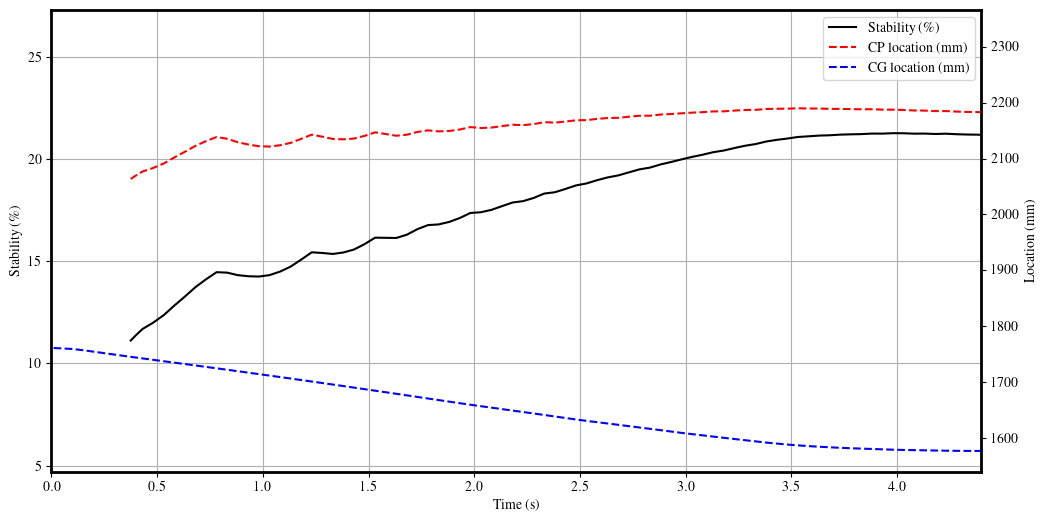

In [15]:
"""Plot Stability data."""
fig, ax1 = plt.subplots(figsize=(12, 6))

# Select y-axis data based on STABILITY_UNIT and plot
ax1.plot(dh.merged_df["time"], dh.merged_df["stability_margin_percentage"],
         "k-", label="Stability ($\mathrm{\%}$)")

ax1.set_xlabel(r"Time ($\mathrm{s}$)")
ax1.set_ylabel(r"Stability ($\mathrm{\%}$)")
ax1.grid(True)

# Plot CP and CG location on a secondary axis
ax2 = ax1.twinx()
ax2.plot(dh.merged_df["time"], dh.merged_df["cp_location"],
         "r--", label="CP location (mm)")
ax2.plot(dh.merged_df["time"], dh.merged_df["cg_location"],
         "b--", label="CG location (mm)")
ax2.set_ylabel("Location (mm)")

# Set x-axis limits based on SHOW_FULL_STABILITY_GRAPH
ax1.set_xlim(0, BURNOUT_TIME)

# Change spine properties to make the border darker and thicker
for spine in ax1.spines.values():
    spine.set_edgecolor('black')  # Change color to black or any other color
    # Change the thickness. Adjust the value as needed.
    spine.set_linewidth(2)

# Combine legends from ax1 and ax2
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc="upper right")

# Plot event markers
# self.plot_event_markers(ax1)

plt.show()

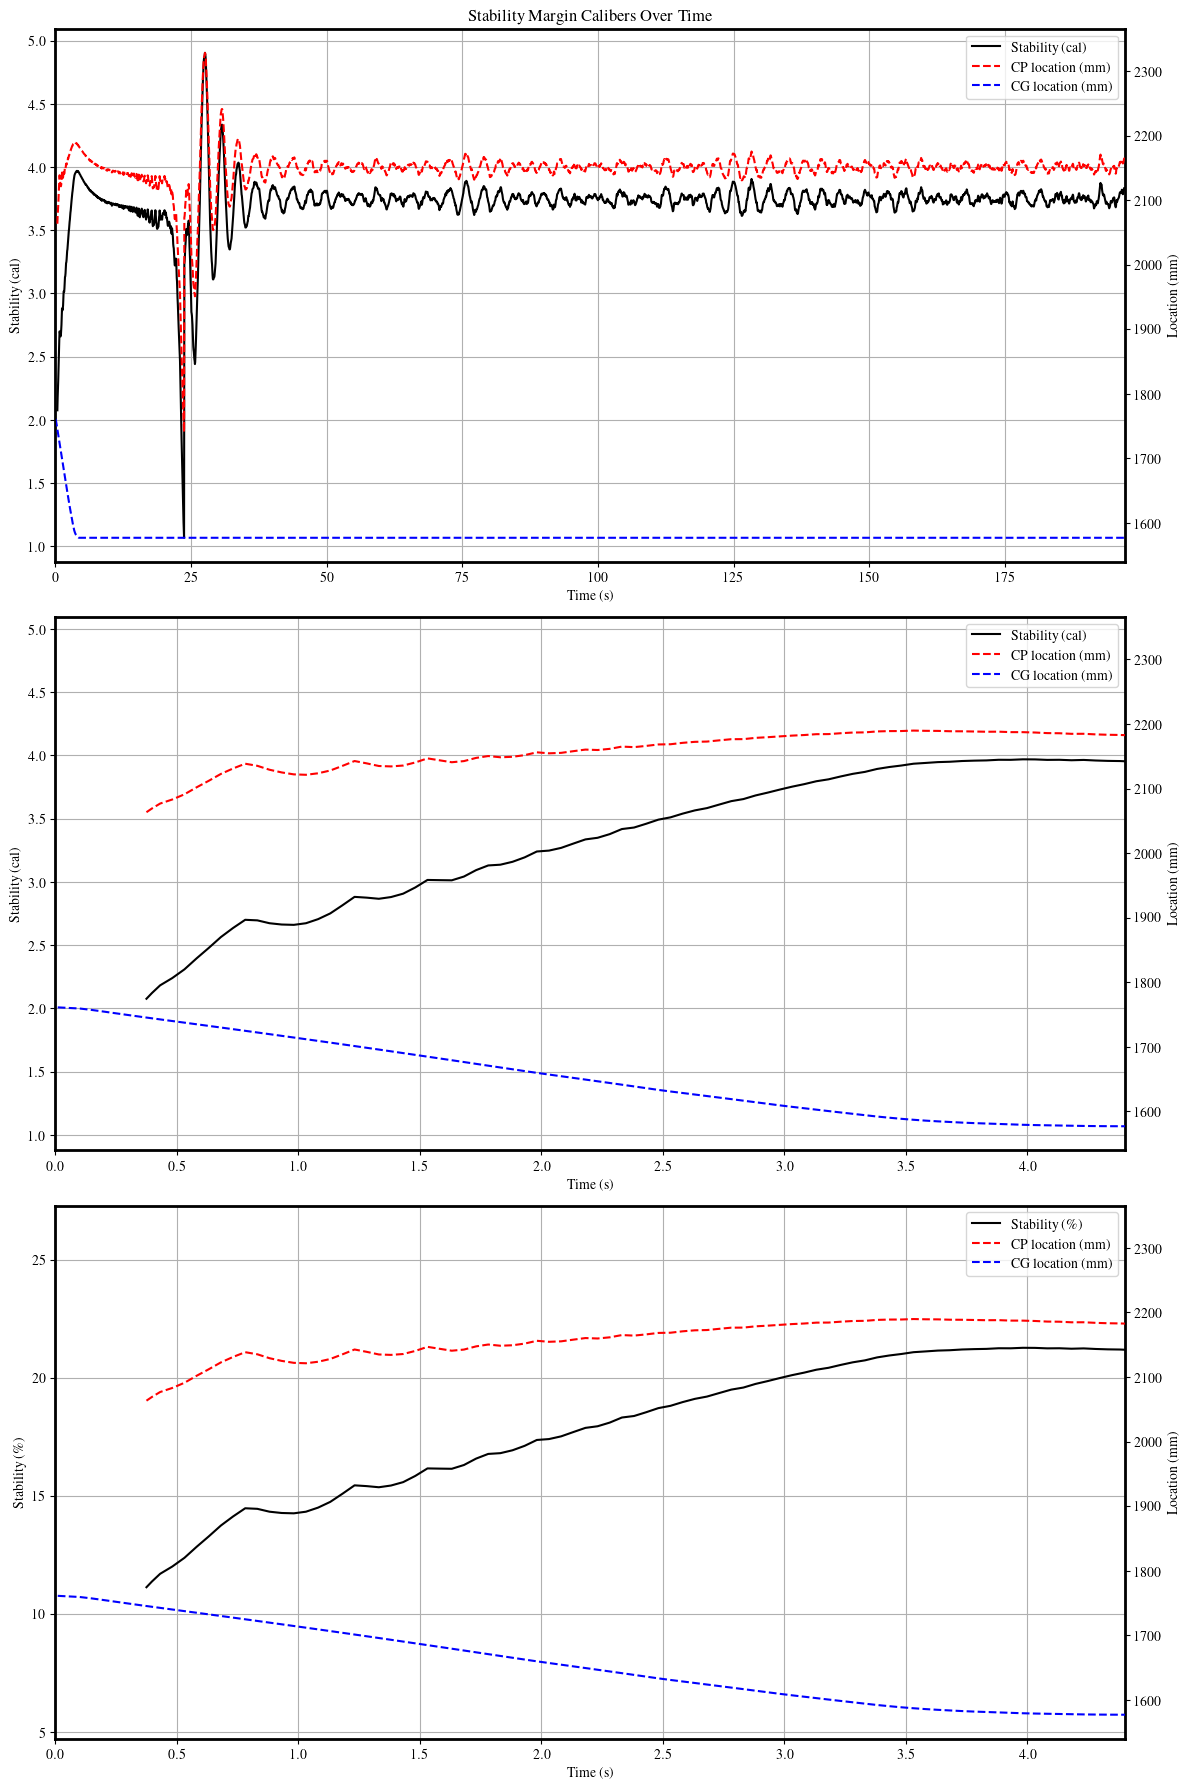

In [16]:
# Create a figure with 3 subplots (rows) and 1 column
fig, axs = plt.subplots(3, 1, figsize=(12, 18))  # Adjust the figsize as needed

# First subplot
ax1 = axs[0]
ax1.plot(dh.merged_df["time"], dh.merged_df["stability_margin_calibers"],
         "k-", label="Stability ($\mathrm{cal}$)")
ax1.set_xlabel(r"Time ($\mathrm{s}$)")
ax1.set_ylabel(r"Stability ($\mathrm{cal}$)")
ax1.grid(True)
ax1.set_xlim(0, dh.merged_df["time"].max())
# Set title for the first subplot
ax1.set_title("Stability Margin Calibers Over Time")

# Second subplot
ax2 = axs[1]
ax2.plot(dh.merged_df["time"], dh.merged_df["stability_margin_calibers"],
         "k-", label="Stability ($\mathrm{cal}$)")
ax2.set_xlabel(r"Time ($\mathrm{s}$)")
ax2.set_ylabel(r"Stability ($\mathrm{cal}$)")
ax2.grid(True)
ax2.set_xlim(0, BURNOUT_TIME)

# Third subplot
ax3 = axs[2]
ax3.plot(dh.merged_df["time"], dh.merged_df["stability_margin_percentage"],
         "k-", label="Stability ($\mathrm{\%}$)")
ax3.set_xlabel(r"Time ($\mathrm{s}$)")
ax3.set_ylabel(r"Stability ($\mathrm{\%}$)")
ax3.grid(True)
ax3.set_xlim(0, BURNOUT_TIME)

# Common settings for all subplots
for ax in axs:
    # Adjust spine properties
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(2)

    # Add secondary axis for CP and CG location
    ax_sec = ax.twinx()
    ax_sec.plot(dh.merged_df["time"], dh.merged_df["cp_location"],
                "r--", label="CP location (mm)")
    ax_sec.plot(dh.merged_df["time"], dh.merged_df["cg_location"],
                "b--", label="CG location (mm)")
    ax_sec.set_ylabel("Location (mm)")

    # Combine legends from primary and secondary axes
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax_sec.get_legend_handles_labels()
    ax.legend(lines + lines2, labels + labels2, loc="upper right")

plt.tight_layout()  # Adjust layout
plt.show()